# Задание 1. Bootstrap

В этом задании используйте датасет breast_cancer — классический датасет для задачи бинарной классификации. Обучите модели:

 - `DecisionTreeClassifier`
 - `RandomForestClassifier`
 - `LGBMClassifier`
 - `SVC`
 - `BaggingClassifier` с базовым класификатором `SVC`.

Параметры моделей можете оставить по умолчанию или задать сами.

Для каждой модели посчитайте [корреляцию Мэтьюса](https://en.wikipedia.org/wiki/Phi_coefficient) — метрику для оценки качества бинарной классификации, в частности, устойчивую к дисбалансу классов, ([`sklearn.metrics.matthews_corrcoef`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html), подробнее почитать про его пользу можно [здесь](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7)) — для предсказанного ею класса и реального.

С помощью bootstrap-подхода постройте 90% доверительные интервалы для качества полученных моделей. Используйте функцию `bootstrap_metric()` из лекции.

Постройте [боксплоты](https://seaborn.pydata.org/generated/seaborn.boxplot.html) для качества полученных моделей.

Импорт необходимых библиотек:

In [1]:
import lightgbm
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.datasets
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.metrics import matthews_corrcoef
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

Загрузка датасета:

In [2]:
breast_cancer = sklearn.datasets.load_breast_cancer()
print(breast_cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [12]:
x = breast_cancer.data
y = breast_cancer.target
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [11]:
clc = SVC(random_state=0)
clf.fit(x_train, y_train)
y_pred1 = clf.predict(x_test)
print(matthews_corrcoef(y_test, y_pred1))

0.8548351525379624


In [13]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(x_train, y_train)
y_pred2 = clf.predict(x_test)

print(matthews_corrcoef(y_test, y_pred2))

0.8548351525379624


In [15]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(x_train, y_train)
y_pred3 = clf.predict(x_test)

print(matthews_corrcoef(y_test, y_pred3))

0.940477037066757


In [17]:
from sklearn.ensemble import BaggingClassifier


clf = BaggingClassifier(n_estimators=10, random_state=0).fit(x_train, y_train)
y_pred4 = clf.predict(x_test)

print(matthews_corrcoef(y_test, y_pred4))

0.8822275826137275


In [18]:
def bootstrap_metric(x, y, metric_fn, samples_cnt=1000, random_state=42):
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)

        x_boot = x[poses]
        y_boot = y[poses]
        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val

    return b_metric

In [19]:
boot_f1score_m1 = bootstrap_metric(
    y_test, y_pred1, metric_fn=lambda x, y: matthews_corrcoef(y_true=x, y_pred=y)
)
boot_f1score_m2 = bootstrap_metric(
    y_test, y_pred2, metric_fn=lambda x, y: matthews_corrcoef(y_true=x, y_pred=y)
)
boot_f1score_m3 = bootstrap_metric(
    y_test, y_pred3, metric_fn=lambda x, y: matthews_corrcoef(y_true=x, y_pred=y)
)
boot_f1score_m4 = bootstrap_metric(
    y_test, y_pred4, metric_fn=lambda x, y: matthews_corrcoef(y_true=x, y_pred=y)
)

In [20]:
alpha = 0.10
print(
    "matthews_corrcoef score for the 1st model: ",
    np.quantile(boot_f1score_m1, q=[alpha / 2, 1 - alpha / 2]),
)
print(
    "matthews_corrcoef score for the 2st model: ",
    np.quantile(boot_f1score_m2, q=[alpha / 2, 1 - alpha / 2]),
)
print(
    "matthews_corrcoef score for the 3st model: ",
    np.quantile(boot_f1score_m3, q=[alpha / 2, 1 - alpha / 2]),
)
print(
    "matthews_corrcoef score for the 4st model: ",
    np.quantile(boot_f1score_m4, q=[alpha / 2, 1 - alpha / 2]),
)

matthews_corrcoef score for the 1st model:  [0.77790878 0.92734472]
matthews_corrcoef score for the 2st model:  [0.77790878 0.92734472]
matthews_corrcoef score for the 3st model:  [0.88953352 0.98517822]
matthews_corrcoef score for the 4st model:  [0.81296945 0.94345159]


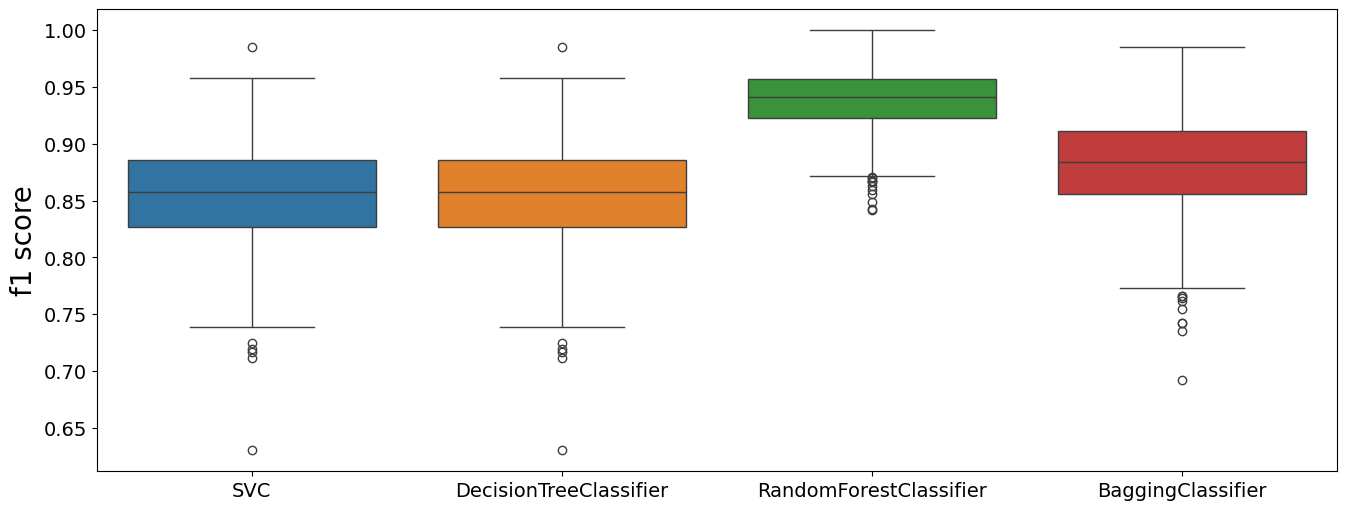

In [21]:
import pandas as pd


plt.figure(figsize=(16, 6))
sns.boxplot(
    data=pd.DataFrame(
        {
            "SVC": boot_f1score_m1,
            "DecisionTreeClassifier": boot_f1score_m2,
            "RandomForestClassifier": boot_f1score_m3,
            "BaggingClassifier":boot_f1score_m4,
        }
    )
)
plt.ylabel("f1 score", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

Очевидно лучшей моделью в рамках данной задачи является RandomForestClassifier - так как у него высокая точность

Сделайте вывод о том, какие модели работают лучше.

**Напишите вывод**

## Формат результата

График с демонстрацией корреляции Мэтьюса для следующих моделей:

 - `DecisionTreeClassifier`
 - `RandomForestClassifier`
 - `LGBMClassifier`
 - `SVC`
 - `BaggingClassifier` с базовым класификатором `SVC`

Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/Exercises/EX03/result_1_task_ex03.png" width="600">

# Задание 2. Дисбаланс классов

Установка и импорт необходимых библиотек:

In [22]:
!pip install -qU imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 5.6 MB/s eta 0:00:00


In [23]:
import imblearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    cross_validate,
)

Важно обращать внимание на сбалансированность классов в наборе.
Предположим, у нас есть некоторый набор данных со следующими метками классов:

In [24]:
real_labels = [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]

В наборе 16 объектов относятся к классу 0, а 5 — к классу 1.

Мы обучили две модели. Первая всегда выдает 0:

In [25]:
model1_res = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Вторая сумела обнаружить некоторую закономерность в признаках:

In [26]:
model2_res = [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1]

Рассчитаем точность Accuracy (см. лекцию 1) для этих моделей:

In [27]:
print("Accuracy for model1: ", accuracy_score(real_labels, model1_res))
print("Accuracy for model2: ", accuracy_score(real_labels, model2_res))

Accuracy for model1:  0.7619047619047619
Accuracy for model2:  0.7619047619047619


Accuracy нельзя использовать, если данные не сбалансированы. Для несбалансированных данных необходимо использовать свои метрики и модели. Одной из таких метрик является balanced accuracy. При вычислении данной метрики считается полнота (recall) отдельно для каждого класса и вычисляется среднее значение:

In [28]:
# Balanced accuracy for model1 = (16/16+0/5)/2 = 0.5
print(
    "Balanced accuracy for model1: ", balanced_accuracy_score(real_labels, model1_res)
)
# Balanced accuracy for model2 = (12/16+4/5)/2 = 0.775
print(
    "Balanced accuracy for model2: ", balanced_accuracy_score(real_labels, model2_res)
)

Balanced accuracy for model1:  0.5
Balanced accuracy for model2:  0.775


**Всегда проверяйте**, являются ли ваши данные сбалансированными и могут ли выбранные для оценки модели метрики работать с несбалансированными классами.

Загрузим датасет с различными биомаркерами пациентов с меланомой (обезличенный, информации о пациентах нет) и переменной, содержащей 1, если пациент ответил на иммунотерапию (терапия помогла пациенту и произошло уменьшение размеров опухоли), и 0, если не ответил. Количество пациентов, отвечающих на терапию, сильно меньше пациентов, которым терапия не помогает, поэтому предсказание ответа пациента на терапию на основании биомаркеров — актуальная задача в онкологии. В данном задании вам предстоит попробовать её решить.

In [29]:
cancer = pd.read_table(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/Cancer_dataset_2.tsv",
    index_col="sample_id",
)
display(cancer.head())

# split the data on features (x) and dependant variable (y)
y = cancer["Response"]
x = cancer.drop("Response", axis=1)
print("\nNumber of patients responded to immunotherapy:")
display(y.value_counts())

,IgG1/IgA,IL21,CXCL9,CXCL10,CD8A,GZMB,KLRC2,KLRC3,KLRC4,GNLY,TGFB1,Response
sample_id,,,,,,,,,,,,
SAM4b0175e8db6e,3.242746,0.001280,-0.002986,-0.036366,0.096658,0.063467,0.502058,-0.083862,0.053659,0.091930,61.934119,0
SAMd215b503f99a,2.139016,-0.000089,0.030495,0.243958,0.161128,0.565798,-0.203495,-0.026902,-0.035405,0.030125,103.265837,0
SAM7fb6987514a4,12.614972,0.008103,0.502043,0.530783,0.388455,0.528142,-0.156209,0.001147,-0.028690,0.260703,53.552817,0
SAMd636e3461955,6.365973,-0.000139,0.024035,0.115127,0.084455,0.200038,-0.387373,-0.057837,0.045938,0.073192,80.837318,0
SAMc0da5d48686d,2.764089,0.006107,0.015533,0.135470,0.067686,0.053499,-0.116040,0.063714,0.088201,0.082940,114.422926,0



Number of patients responded to immunotherapy:


0    228
1     37
Name: Response, dtype: int64

В данном случае имеет место несбалансированность классов в наборе данных: пациентов, ответивших на терапию, гораздо меньше.

Есть два способа работы с несбалансированными по классам данными. Первый способ &mdash; это получение стратифицированных выборок. Необходимо иметь одинаковую долю образцов каждого класса в тренировочной и тестовой выборках, иначе возникает риск получения смещённых выборок, что приводит к некорректной оценке качества модели. Второй способ &mdash; это использование специальных алгоритмов, учитывающих несбалансированность классов.


В данном задании вам нужно продемонстрировать эффективность различных подходов  работы с несбалансированными выборками. Для этого вы будете использовать три модели, представленные ниже:

1. [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), библиотека sklearn
2. [`RandomForestClassifier` с балансировкой классов](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), библиотека sklearn — меняет стандартный вес каждого класса, равный 1, на долю класса во входных данных (см. `class_weight`).
3. [`BalancedRandomForestClassifier`](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html), библиотека imblearn — сэмплирует псевдовыборки таким образом, что в каждой псевдовыборке, которая подается на вход модели, баланс классов оказывается "выправлен".

Оцените эффективность подходов с помощью кросс-валидации, производя разбиение с учетом репрезентации классов и без него. В качестве метрики, отображающей эффективность модели, используйте значения `accuracy` и `balanced_accuracy`. Проинтерпретируйте результаты.

In [30]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [32]:
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier()
clf.fit(x_train, y_train)

accuracy_score(y_test, clf.predict(x_test))

0.8955223880597015

In [33]:
clf = RandomForestClassifier(class_weight = 'balanced_subsample')
clf.fit(x_train, y_train)

accuracy_score(y_test, clf.predict(x_test))

0.8955223880597015

In [34]:
clf = BalancedRandomForestClassifier()
clf.fit(x_train, y_train)

accuracy_score(y_test, clf.predict(x_test))

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


0.6865671641791045

In [37]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

rf_clf = RandomForestClassifier(random_state=42)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores_rf = cross_val_score(rf_clf, x_train, y_train, cv=kf, scoring='accuracy')
balanced_scores_rf = cross_val_score(rf_clf, x_train, y_train, cv=kf, scoring='balanced_accuracy')

print(scores_rf)
print(balanced_scores_rf)

[0.85       0.875      0.825      0.84615385 0.87179487]
[0.56862745 0.58333333 0.48529412 0.56818182 0.58333333]


Объекты, принадлежащие разным классам, распределены неравномерно. Для адекватной работы cross_validate нужно перемешать данные. Для этого используйте флаг `shuffle=True`, применяя `KFold` и `StratifiedKFold` (см. параметр `cv` в функции cross_validate).

In [ ]:
from sklearn.model_selection import cross_val_score

rf_clf = BalancedRandomForestClassifier()


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores_rf = cross_val_score(rf_clf, x_train, y_train, cv=kf, scoring='accuracy')
balanced_scores_rf = cross_val_score(rf_clf, x_train, y_train, cv=kf, scoring='balanced_accuracy')

print(scores_rf)
print(balanced_scores_rf)

In [39]:
from sklearn.model_selection import cross_val_score

rf_clf = RandomForestClassifier(class_weight = 'balanced_subsample')


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores_rf = cross_val_score(rf_clf, x_train, y_train, cv=kf, scoring='accuracy')
balanced_scores_rf = cross_val_score(rf_clf, x_train, y_train, cv=kf, scoring='balanced_accuracy')

print(scores_rf)
print(balanced_scores_rf)

[0.875      0.875      0.85       0.84615385 0.84615385]
[0.66666667 0.58333333 0.5        0.56818182 0.5       ]


In [40]:
from sklearn.model_selection import cross_val_score

rf_clf = RandomForestClassifier(class_weight = 'balanced_subsample')


kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores_rf = cross_val_score(rf_clf, x_train, y_train, cv=kf, scoring='accuracy')
balanced_scores_rf = cross_val_score(rf_clf, x_train, y_train, cv=kf, scoring='balanced_accuracy')

print(scores_rf)
print(balanced_scores_rf)

[0.875      0.9        0.85       0.71794872 0.8974359 ]
[0.58333333 0.5        0.48571429 0.53275862 0.6       ]


Сбалансированная точность меньше,: чем стандартная точность, так как она учитывает неверное разбиение на классы.
Разницы между KFold и St=ratifiedKFold не заметил, хотя поидее она должна быть.

## Формат результата

Получить значения `accuracy` и `balanced_accuracy`для моделей:
1. `RandomForestClassifier`, библиотека sklearn;
2. `RandomForestClassifier с балансировкой классов`, библиотека sklearn;
3. `BalancedRandomForestClassifier`, библиотека imblearn;

оцененные на кросс-валидации с учетом стратификации по классам и без.

# Задание 3. Разные типы бустингов

В этом задании будем использовать датасет с рейтингом блюд по некоторым характеристикам.

В некоторых реализациях градиентного бустинга есть возможность использовать другой метод обучения. Например, в XGB есть тип `dart`, а в lgbm — `goss`. Это позволяет составлять более эффективные ансамбли.

Используя кросс-валидацию (используйте 3 фолда), обучите модели:
* `CatBoostRegressor`
* `XGBRegressor`
* `LGBMRegressor`

Сохраните модель на каждом фолде и посчитайте `mse` для тестовой выборки, используя модель с каждого фолда. Получите предсказания всех 9 моделей на тестовой выборке и усредните их. Затем посчитайте `mse` для усредненных предсказаний.

Напишите выводы о полученном качестве моделей.

Установка и импорт необходимых библиотек:

In [41]:
!pip install -q catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.5 MB/s eta 0:00:00


In [42]:
import xgboost
import catboost
import lightgbm
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, KFold

Загрузка датасета:

In [43]:
recipies = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/recipes.csv"
)
recipies

,calories,protein,fat,sodium,cakeweek,wasteless,rating
0,426.0,30.0,7.0,559.0,0.0,0.0,2.500
1,403.0,18.0,23.0,1439.0,0.0,0.0,4.375
2,165.0,6.0,7.0,165.0,0.0,0.0,3.750
3,547.0,20.0,32.0,452.0,0.0,0.0,3.125
4,948.0,19.0,79.0,1042.0,0.0,0.0,4.375
...,...,...,...,...,...,...,...
15859,28.0,2.0,2.0,64.0,0.0,0.0,3.125
15860,671.0,22.0,28.0,583.0,0.0,0.0,4.375
15861,563.0,31.0,38.0,652.0,0.0,0.0,4.375
15862,631.0,45.0,24.0,517.0,0.0,0.0,4.375


In [44]:
y = recipies["rating"]
x = recipies.drop(["rating"], axis=1)

x_train_all, x_test, y_train_all, y_test = train_test_split(
    x.values, y.values, train_size=0.7, random_state=42
)

In [ ]:
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor

rf_clf = CatBoostRegressor()

kf = KFold(n_splits=3, shuffle=True, random_state=42)

balanced_scores_rf = cross_val_score(rf_clf, x_train_all, y_train_all, cv=kf, scoring='neg_mean_squared_error', verbose=0)

print(balanced_scores_rf)
res = abs(np.mean(balanced_scores_rf))

In [47]:
print(res)

1.558188035458187


In [48]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


rf_clf = XGBRegressor()


kf = KFold(n_splits=3, shuffle=True, random_state=42)

balanced_scores_rf = cross_val_score(rf_clf, x_train_all, y_train_all, cv=kf, scoring='neg_mean_squared_error', verbose=0)

print(balanced_scores_rf)
res = abs(np.mean(balanced_scores_rf))

[-1.62130865 -1.67147928 -1.64502224]


In [49]:
print(res)

1.6459367230899042


In [50]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error


rf_clf = LGBMRegressor()


kf = KFold(n_splits=3, shuffle=True, random_state=42)

balanced_scores_rf = cross_val_score(rf_clf, x_train_all, y_train_all, cv=kf, scoring='neg_mean_squared_error', verbose=0)

print(balanced_scores_rf)
res = abs(np.mean(balanced_scores_rf))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 825
[LightGBM] [Info] Number of data points in the train set: 7402, number of used features: 4
[LightGBM] [Info] Start training from score 3.760977
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 7403, number of used features: 4
[LightGBM] [Info] Start training from score 3.758611
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info] Number of data points in the train set: 7403, number of used features: 4
[LightGBM] [Info] Start training fro

In [51]:
print(res)

1.5830849222897092


## Вывод:
Лучшая модель для данной даты - XGBRegressor()!!!!!


Получить значения MSE для всех моделей и среднее значение MSE по предсказаниям всех моделей. Написать вывод.


# Задание 4. Подбор гиперпараметров

В этом задании нужно подобрать параметры для бустинга `CatBoostRegressor`, используя библиотеку `optuna`. И улучшить результат по сравнению со стандартными параметрами.

Список параметров для подбора:

* `depth`
* `iterations`
* `learning_rate`
* `colsample_bylevel`
* `subsample`
* `l2_leaf_reg`
* `min_data_in_leaf`
* `max_bin`
* `random_strength`
* `bootstrap_type`

**Важно!** *Подбирать параметры нужно на валидационной выборке*

Установка и импорт необходимых библиотек:

In [52]:
!pip install -q catboost
!pip install -q optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.4 MB/s eta 0:00:00


In [53]:
import optuna
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from optuna.samplers import RandomSampler
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, KFold

Загрузка датасета:

In [54]:
recipies = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/recipes.csv"
)

In [63]:
y = recipies["rating"]
x = recipies.drop(["rating"], axis=1)

# x_train_all, x_test, y_train_all, y_test = train_test_split(
#     x.values, y.values, train_size=0.7, random_state=42
# )


x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=42)

In [64]:
model = CatBoostRegressor(random_seed=42)

model.fit(
    x_train_all,
    y_train_all,
    eval_set=(x_test, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

print("\nmse_score before tuning: ", mse(y_test, model.predict(x_test)))

Learning rate set to 0.074308
0:	learn: 1.2817437	test: 1.2426123	best: 1.2426123 (0)	total: 4.07ms	remaining: 4.07s
200:	learn: 1.1884099	test: 1.2085599	best: 1.2082339 (193)	total: 552ms	remaining: 2.19s
400:	learn: 1.1488674	test: 1.2094838	best: 1.2081885 (320)	total: 1.09s	remaining: 1.63s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.208188477
bestIteration = 320

Shrink model to first 321 iterations.

mse_score before tuning:  1.4597193954968208


In [78]:
from sklearn.metrics import mean_squared_error

In [79]:
import optuna
import numpy as np
from catboost import CatBoostRegressor, cv, Pool
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Предполагается, что x и y уже загружены в вашу среду выполнения

# Деление данных на тренировочный и тестовый наборы
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=42) # 0.25 * 0.8 = 0.2

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 100, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'max_bin': trial.suggest_int('max_bin', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 0.1, 1.0),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli']),
        'loss_function': 'RMSE',
        'random_seed': 42,
        'silent': True,
    }

    train_pool = Pool(x_train, y_train)

    cv_results = cv(
        params=params,
        pool=train_pool,
        fold_count=5,
        partition_random_seed=42,
        shuffle=True,
        stratified=False,
        verbose=False
    )

    mean_mse = np.mean(cv_results['test-RMSE-mean'])
    return mean_mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print("Лучшие параметры:", study.best_params)

# Обучение модели с лучшими параметрами на тренировочном и валидационном наборах данных
final_model = CatBoostRegressor(**study.best_params, random_seed=42, silent=True)
final_model.fit(x_train_val, y_train_val)

# Оценка MSE на тестовом наборе данных
y_pred = final_model.predict(x_test)
mse_test = mean_squared_error(y_test, y_pred)

print("MSE на тестовом наборе:", mse_test)


[I 2024-03-14 18:28:41,033] A new study created in memory with name: no-name-deb4923f-6e0f-4e61-969b-a6a25e364988


Training on fold [0/5]

bestTest = 1.28020138
bestIteration = 114

Training on fold [1/5]

bestTest = 1.236277329
bestIteration = 68

Training on fold [2/5]

bestTest = 1.202955897
bestIteration = 191

Training on fold [3/5]

bestTest = 1.283762743
bestIteration = 127

Training on fold [4/5]


[I 2024-03-14 18:29:03,757] Trial 0 finished with value: 1.2896391702241472 and parameters: {'iterations': 931, 'learning_rate': 0.08739528299631436, 'depth': 9, 'colsample_bylevel': 0.7868689881643873, 'l2_leaf_reg': 9.986900632815545e-05, 'min_data_in_leaf': 33, 'max_bin': 121, 'random_strength': 0.5955266867241721, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 1.2896391702241472.



bestTest = 1.240673196
bestIteration = 218

Training on fold [0/5]

bestTest = 1.284046178
bestIteration = 493

Training on fold [1/5]

bestTest = 1.236456992
bestIteration = 444

Training on fold [2/5]

bestTest = 1.20709872
bestIteration = 531

Training on fold [3/5]

bestTest = 1.287737414
bestIteration = 531

Training on fold [4/5]


[I 2024-03-14 18:29:08,405] Trial 1 finished with value: 1.5140235445659818 and parameters: {'iterations': 532, 'learning_rate': 0.01310340444392436, 'depth': 4, 'colsample_bylevel': 0.9977956702402404, 'l2_leaf_reg': 23.065994744808446, 'min_data_in_leaf': 37, 'max_bin': 70, 'random_strength': 0.1301025813637465, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.2896391702241472.



bestTest = 1.247515464
bestIteration = 514

Training on fold [0/5]

bestTest = 1.282811011
bestIteration = 398

Training on fold [1/5]

bestTest = 1.239992207
bestIteration = 234

Training on fold [2/5]

bestTest = 1.203477052
bestIteration = 738

Training on fold [3/5]

bestTest = 1.284253859
bestIteration = 553

Training on fold [4/5]


[I 2024-03-14 18:29:12,776] Trial 2 finished with value: 1.3556470159714529 and parameters: {'iterations': 743, 'learning_rate': 0.02308782998005454, 'depth': 5, 'colsample_bylevel': 0.829368798190724, 'l2_leaf_reg': 1.1059658668398474e-07, 'min_data_in_leaf': 45, 'max_bin': 52, 'random_strength': 0.15233682039805013, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 1.2896391702241472.



bestTest = 1.245684742
bestIteration = 567

Training on fold [0/5]

bestTest = 1.277023628
bestIteration = 452

Training on fold [1/5]

bestTest = 1.235232618
bestIteration = 357

Training on fold [2/5]

bestTest = 1.196235333
bestIteration = 503

Training on fold [3/5]

bestTest = 1.280744387
bestIteration = 506

Training on fold [4/5]


[I 2024-03-14 18:29:24,151] Trial 3 finished with value: 1.4991742673602833 and parameters: {'iterations': 508, 'learning_rate': 0.01406008678910975, 'depth': 9, 'colsample_bylevel': 0.8604374846925429, 'l2_leaf_reg': 1.7357004509136372e-07, 'min_data_in_leaf': 4, 'max_bin': 106, 'random_strength': 0.16507462261667877, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 1.2896391702241472.



bestTest = 1.240225222
bestIteration = 478

Training on fold [0/5]

bestTest = 1.283751365
bestIteration = 633

Training on fold [1/5]

bestTest = 1.235100025
bestIteration = 283

Training on fold [2/5]

bestTest = 1.202822147
bestIteration = 698

Training on fold [3/5]

bestTest = 1.284697287
bestIteration = 700

Training on fold [4/5]


[I 2024-03-14 18:29:31,259] Trial 4 finished with value: 1.3868578514967862 and parameters: {'iterations': 716, 'learning_rate': 0.01908635977973409, 'depth': 7, 'colsample_bylevel': 0.8202041561114162, 'l2_leaf_reg': 14.16278661743151, 'min_data_in_leaf': 30, 'max_bin': 94, 'random_strength': 0.7923316178369446, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 1.2896391702241472.



bestTest = 1.246858815
bestIteration = 710

Training on fold [0/5]

bestTest = 1.282292726
bestIteration = 434

Training on fold [1/5]

bestTest = 1.235107803
bestIteration = 322

Training on fold [2/5]

bestTest = 1.203057388
bestIteration = 445

Training on fold [3/5]

bestTest = 1.284499644
bestIteration = 418

Training on fold [4/5]


[I 2024-03-14 18:29:36,924] Trial 5 finished with value: 1.3834964669725374 and parameters: {'iterations': 451, 'learning_rate': 0.02948116726330539, 'depth': 5, 'colsample_bylevel': 0.940762673273464, 'l2_leaf_reg': 3.508878597813937e-07, 'min_data_in_leaf': 23, 'max_bin': 193, 'random_strength': 0.2607419037139973, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.2896391702241472.



bestTest = 1.242565763
bestIteration = 297

Training on fold [0/5]

bestTest = 3.271863715
bestIteration = 120

Training on fold [1/5]

bestTest = 3.263559702
bestIteration = 120

Training on fold [2/5]

bestTest = 3.278094962
bestIteration = 120

Training on fold [3/5]

bestTest = 3.2222372
bestIteration = 120

Training on fold [4/5]


[I 2024-03-14 18:29:39,305] Trial 6 finished with value: 3.600826040501763 and parameters: {'iterations': 121, 'learning_rate': 0.0018644368081953788, 'depth': 9, 'colsample_bylevel': 0.6172427709138002, 'l2_leaf_reg': 0.0430922266027728, 'min_data_in_leaf': 14, 'max_bin': 152, 'random_strength': 0.10897028029495576, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.2896391702241472.



bestTest = 3.277213499
bestIteration = 120

Training on fold [0/5]

bestTest = 1.280766183
bestIteration = 812

Training on fold [1/5]

bestTest = 1.236869906
bestIteration = 810

Training on fold [2/5]

bestTest = 1.207143771
bestIteration = 818

Training on fold [3/5]

bestTest = 1.28515347
bestIteration = 818

Training on fold [4/5]


[I 2024-03-14 18:29:52,240] Trial 7 finished with value: 1.602473978888827 and parameters: {'iterations': 819, 'learning_rate': 0.006323634434630552, 'depth': 9, 'colsample_bylevel': 0.86703226276554, 'l2_leaf_reg': 1.4127405215123042e-08, 'min_data_in_leaf': 24, 'max_bin': 66, 'random_strength': 0.8497342659663844, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.2896391702241472.



bestTest = 1.248157516
bestIteration = 818

Training on fold [0/5]

bestTest = 1.69051956
bestIteration = 152

Training on fold [1/5]

bestTest = 1.666985396
bestIteration = 152

Training on fold [2/5]

bestTest = 1.670957234
bestIteration = 152

Training on fold [3/5]

bestTest = 1.661140723
bestIteration = 152

Training on fold [4/5]


[I 2024-03-14 18:29:53,206] Trial 8 finished with value: 2.5282975447999863 and parameters: {'iterations': 153, 'learning_rate': 0.008120642287379468, 'depth': 4, 'colsample_bylevel': 0.7095534119267795, 'l2_leaf_reg': 6.161556496300177, 'min_data_in_leaf': 42, 'max_bin': 79, 'random_strength': 0.6863369250073931, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 1.2896391702241472.



bestTest = 1.682272879
bestIteration = 152

Training on fold [0/5]

bestTest = 1.280182153
bestIteration = 680

Training on fold [1/5]

bestTest = 1.23603199
bestIteration = 672

Training on fold [2/5]

bestTest = 1.200039676
bestIteration = 678

Training on fold [3/5]

bestTest = 1.284853869
bestIteration = 681

Training on fold [4/5]


[I 2024-03-14 18:30:19,665] Trial 9 finished with value: 1.5345007822749352 and parameters: {'iterations': 682, 'learning_rate': 0.009371292942368672, 'depth': 10, 'colsample_bylevel': 0.642778980888152, 'l2_leaf_reg': 0.2764758714689273, 'min_data_in_leaf': 27, 'max_bin': 209, 'random_strength': 0.5325012722706207, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.2896391702241472.



bestTest = 1.241822961
bestIteration = 674

Лучшие параметры: {'iterations': 931, 'learning_rate': 0.08739528299631436, 'depth': 9, 'colsample_bylevel': 0.7868689881643873, 'l2_leaf_reg': 9.986900632815545e-05, 'min_data_in_leaf': 33, 'max_bin': 121, 'random_strength': 0.5955266867241721, 'bootstrap_type': 'Bernoulli'}
MSE на тестовом наборе: 1.4496252987161369


## Формат результата

Значение `mse` с подобранными параметрами меньше, чем при стандартных параметрах.

# Задание 5. Ансамблевое обучение (дополнительно)

В данной задаче вам нужно диагностировать сердечное заболевание у людей по [медицинским показателям](https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci).

Установка и импорт необходимых библиотек:

In [ ]:
!pip install -q catboost
!pip install -q lightgbm==3.0

In [ ]:
import catboost
import lightgbm
import xgboost
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
)
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    VotingClassifier,
)

Загрузка датасета:

In [ ]:
heart_dataset = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/heart.csv"
)

In [ ]:
x = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`.

In [ ]:
rng = np.random.RandomState(42)

dt = DecisionTreeClassifier(random_state=rng, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=rng)
etc = ExtraTreesClassifier(random_state=rng)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel="linear", probability=True, random_state=rng)
svc_rbf = SVC(kernel="rbf", probability=True, random_state=rng)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=42)
lgbm = lightgbm.LGBMClassifier(random_state=42, verbose=-1)
lgbm_rf = lightgbm.LGBMClassifier(
    boosting_type="rf", subsample_freq=1, subsample=0.7, random_state=42, verbose=-1
)
xgb = xgboost.XGBClassifier(random_state=42)
xgb_rf = xgboost.XGBRFClassifier(random_state=42)
lr = LogisticRegression(solver="liblinear", max_iter=10000)
nb = GaussianNB()

# Your code here

voting_hard =
voting_soft =
# -----------


for model in [voting_hard, voting_soft]:
    scores = cross_val_score(
        model,
        x_train,
        y_train,
        cv=KFold(n_splits=3, shuffle=True, random_state=rng),
        scoring="f1",
    )
    print(f"{model.__class__.__name__}: {scores.mean()}")

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них, не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тренировочном наборе и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Можете модифицировать функцию `base_model_pair_correlation` из лекции.

In [ ]:
# Your code here

Создайте новый ансамбль, на исправленном наборе моделей и оцените его качество с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`.

In [ ]:
# Your code here

voting_hard_2 =
voting_soft_2 =
# ------------

for model in [voting_hard_2, voting_soft_2]:
    scores = cross_val_score(
        model,
        x_train,
        y_train,
        cv=KFold(n_splits=3, shuffle=True, random_state=rng),
        scoring="f1",
    )
    print(f"{model.__class__.__name__}: {scores.mean()}")

Обучите все получившиеся модели на тренировочном наборе и испытайте их качество на тестовом наборе. Получилось ли у улучшенных версий ансамблевого классификатора превзойти базовые модели, входящие в него, и свои предыдущие версии?

In [ ]:
# Your code here

Какие ансамбли работают лучше? Всегда ли больше моделей значит лучше?

**Напишите вывод**

## Формат результата

Получить значения качества для ансамблей и моделей.